In [2]:
import pandas as pd
import numpy as np
import os
from utils import *
import cvxpy as cp
from datetime import timedelta


In [3]:
def get_index_price(index:str, start_date:str, end_date:str, field:str='close'):
    index_list = ['000300.SH', '000905.SH', '000852.SH', '000985.SH']
    if index not in index_list:
        print(f'pleace select from {index_list}')
    
 
    return index.pivot(index='trade_date', columns='ts_code', values=field)

def port_opt(period_list, industry_list, barra_list, past_weight, stock_today, index_today, barra_limit, turnover=0.20):
    # 定义要优化的变量，设置非负约束
    weights = cp.Variable(shape=(len(stock_today), 1), nonneg=True)

    # 收集约束条件
    constraints = []

    # 1. 权重之和等于1
    constraints.append(cp.sum(weights) == 1)

    # 2. 个股权重限制为1%
    constraints.append(weights <= 0.01)

    # # 3. 行业权重限制与指数的差异限制为5%
    constraints.append(weights[:, 0] @ stock_today[industry_list] - index_today[industry_list] <= 0.5)
    constraints.append(weights[:, 0] @ stock_today[industry_list] - index_today[industry_list] >= -0.5)

    # 4. barra 偏离限制
    # for _barra in barra_list:
    #     constraints.append(weights[:, 0] @ stock_today[_barra] - index_today[_barra] <= barra_limit)
    #     constraints.append(weights[:, 0] @ stock_today[_barra] - index_today[_barra] >= -barra_limit)
    constraints.append(weights[:, 0] @ stock_today[barra_list] - index_today[barra_list] <= barra_limit)
    constraints.append(weights[:, 0] @ stock_today[barra_list] - index_today[barra_list] >= -barra_limit)

    # 5. 限制换手率（权重变化的总和）为15%
    trade_cost_sum = cp.sum(cp.abs(weights - past_weight[['past_weight']].iloc[:len(stock_today)]))

    # if past_weight['past_weight'].sum() > 0.5:  # 首日排除
    #     constraints.append(trade_cost_sum <= turnover)  # 单日换手不超过15%

    # 定义目标函数
    profit_sum = cp.sum(cp.multiply(weights, stock_today[period_list])) 
    obj = profit_sum 

    # 传递问题给求解器
    problem = cp.Problem(cp.Maximize(obj), constraints)

    try:
        problem.solve(solver='ECOS', qcp=True, max_iters=2000)
    except:
        problem.solve()

    weights_value = weights.value
    # if weights_value is None:
    #     return past_weight.set_index('Symbol')['past_weight'].to_dict(), problem.status
    weights_value = pd.concat([stock_today[['Symbol']].reset_index(drop=True),
                                pd.DataFrame(weights_value[:, 0], columns=['weight']).reset_index(drop=True)],
                                axis=1)
    weights_value.loc[weights_value['weight'] < 0.00001, 'weight'] = 0
    weights_value = weights_value[weights_value['weight'] != 0]
    weights_value['weight'] = weights_value['weight'] / weights_value['weight'].sum()
    weights_value = pd.merge(left=weights_value, right=past_weight[['Symbol']], on='Symbol', how='outer')
    weights_value.fillna(0, inplace=True)
    weights_value = weights_value.set_index('Symbol')['weight'].to_dict()
    return weights_value, problem.status

def trade_cal(past_weight, holding_df, trade_target, today_stock_return, non_trade, sell_trade_cost = 0.00005, buy_trade_cost = 0.00005, drop_list=[]):
    # pass value includes past hoding merged with today's stock, it contains all stocks, including newly entered stocks
    weight_diff = pd.merge(left=past_weight, right=trade_target, on='Symbol', how='outer')
    weight_diff.fillna(0, inplace=True)
    weight_diff = weight_diff[(weight_diff['past_weight'] != 0) | (weight_diff['trade_weight'] != 0)]  # 有交易的trade_target
    weight_diff = pd.merge(weight_diff, today_stock_return, on=['Symbol'], how='left')
    weight_diff['diff'] = weight_diff['trade_weight'] - weight_diff['past_weight']
    weight_diff.loc[abs(weight_diff['diff']) < 0.001, 'diff'] = 0  # 差距过小的不进行交易
    weight_diff.loc[weight_diff['trade_weight'] == 0, 'diff'] = \
        -weight_diff.loc[weight_diff['trade_weight'] == 0, 'past_weight']


    sell_list = list(weight_diff.loc[np.where((weight_diff['diff'] < 0)
                                                & (weight_diff['vwap_next'] != 0)), 'Symbol'])
    buy_list = list(weight_diff.loc[np.where((weight_diff['diff'] > 0)
                                                & (weight_diff['vwap_next'] != 0)), 'Symbol'])
    stable_list = [stock_ for stock_ in holding_df.index if stock_ not in sell_list + buy_list]
    stable_list.remove('cash')

    if non_trade!=0:
        sell_list = []
        buy_list = []
        stable_list= [stock_ for stock_ in holding_df.index]
        stable_list.remove('cash')

    past_value = holding_df['past_value'].sum()  # 前一天持有的所有资产，因为要提前做交易单，所以按前一天净值算
    # 未停牌的能卖出的按开盘价结算卖出
    total_sell = 0


    for stock_ in sell_list:
        stock_info = weight_diff[weight_diff['Symbol'] == stock_]
        next_holding = holding_df.loc[stock_, 'past_value'] / stock_info['vwap'].iloc[0] \
                        * stock_info['vwap_next'].iloc[0]  # 转日开盘后个股价值
        holding_df.loc['cash', 'past_value'] += -next_holding * stock_info['diff'].iloc[0] \
                                                / stock_info['past_weight'].iloc[0] \
                                                * (1 - sell_trade_cost)  # 卖出部分变现
        holding_df.loc[stock_, 'past_value'] = next_holding * stock_info['trade_weight'].iloc[0] \
                                                / stock_info['past_weight'].iloc[0]  # 持仓改变
        total_sell += -next_holding * stock_info['diff'].iloc[0] \
                                                / stock_info['past_weight'].iloc[0] * (1 - sell_trade_cost)
    
    for stock_ in drop_list:  # 直接被收购退市的，按价值卖出
        if stock_ in holding_df.index:
            holding_df.loc['cash', 'past_value'] += holding_df.loc[stock_, 'past_value'] * (1 - sell_trade_cost)
            holding_df.loc[stock_, 'past_value'] = 0
            total_sell += holding_df.loc[stock_, 'past_value'] * (1 - sell_trade_cost)

    # 剩余的钱且未停牌的按weight重置进行买入
    buy_df = weight_diff[weight_diff['Symbol'].isin(buy_list)]['diff'].sum()
    buy_cash = holding_df.loc['cash'].iloc[0]  # 可以买的钱

    total_buy = 0
    for stock_ in buy_list:
        stock_info = weight_diff[weight_diff['Symbol'] == stock_]
        buy_asset_total = past_value * stock_info['diff'].iloc[0]  # 按总资产计算的购买数量
        buy_asset_cash = buy_cash * stock_info['diff'].iloc[0] / buy_df  # 按现有资金计算的购买量
        buy_asset = min(buy_asset_cash, buy_asset_total)
        holding_df.loc['cash', 'past_value'] -= buy_asset
        if stock_info['past_weight'].iloc[0] == 0:  # 昨日没持仓
            holding_df.loc[stock_, 'past_value'] = buy_asset * (1 - buy_trade_cost)
        else:  # 昨天有持仓
            holding_df.loc[stock_, 'past_value'] = holding_df.loc[stock_, 'past_value'] \
                                                    / stock_info['vwap'].iloc[0] \
                                                    * stock_info['vwap_next'].iloc[0] \
                                                    + buy_asset * (1 - buy_trade_cost)
        total_buy += buy_asset

    # 无操作个股按收盘、开盘结算
    for stock_ in stable_list:
        stock_info = weight_diff[weight_diff['Symbol'] == stock_]
        holding_df.loc[stock_, 'past_value'] = holding_df.loc[stock_, 'past_value'] \
                                                / stock_info['vwap'].iloc[0] \
                                                * stock_info['vwap_next'].iloc[0]  # 转日开盘后个股价值


    # 更新持仓，去除0的
    holding_df = holding_df[holding_df['past_value'] != 0]
    if 'cash' not in holding_df.index:
        holding_df.loc['cash'] = 0
    # holding_df.dropna(inplace=True)

    # 尾盘结算价格
    holding_df.reset_index(inplace=True)

    holding_df.set_index('Symbol', inplace=True)
    turnover_rate = (total_buy + total_sell) / past_value / 2

    return holding_df, turnover_rate

In [4]:
score_path = 'result_week_daily_test.parquet'
startdate = '2012-01-01'
enddate = '2024-10-10'
chosen_index = '000300.SH'
barra_limit = 0.3
trade_freq= 5


In [5]:
# get prediction
score_df = pd.read_parquet(score_path)
score_df.reset_index(inplace=True)
score_df['Date'] = pd.to_datetime(score_df['Date'])
score_df = score_df[['Date', 'Symbol', 'mean']]
score_df.columns = ['Date', 'Symbol', 'pred']
score_df

,Date,Symbol,pred
0,2012-01-02,000001.SZ,-0.000043
1,2012-01-02,000002.SZ,-0.000183
2,2012-01-02,000004.SZ,0.000073
3,2012-01-02,000005.SZ,0.000159
4,2012-01-02,000006.SZ,-0.000012
...,...,...,...
2359999,2024-09-23,688799.SH,0.002559
2360000,2024-09-23,688800.SH,0.002668
2360001,2024-09-23,688819.SH,0.001623
2360002,2024-09-23,688981.SH,0.001900


In [6]:
score_df.Date.unique()

<DatetimeArray>
['2012-01-02 00:00:00', '2012-01-09 00:00:00', '2012-01-16 00:00:00',
 '2012-01-23 00:00:00', '2012-01-30 00:00:00', '2012-02-06 00:00:00',
 '2012-02-13 00:00:00', '2012-02-20 00:00:00', '2012-02-27 00:00:00',
 '2012-03-05 00:00:00',
 ...
 '2024-07-22 00:00:00', '2024-07-29 00:00:00', '2024-08-05 00:00:00',
 '2024-08-12 00:00:00', '2024-08-19 00:00:00', '2024-08-26 00:00:00',
 '2024-09-02 00:00:00', '2024-09-09 00:00:00', '2024-09-16 00:00:00',
 '2024-09-23 00:00:00']
Length: 663, dtype: datetime64[ns]

In [ ]:
# get return data
return_df = get_price([],startdate, enddate)
return_df = return_df.stack().reset_index().rename(columns={0:'vwap'})
return_df['vwap_next'] = return_df.groupby('Symbol')['vwap'].shift(-5)
# if vwap_next is nan, fill with vwap
return_df['vwap_next'].fillna(return_df['vwap'], inplace=True)
return_df['Date'] = pd.to_datetime(return_df['Date'])
return_df

# return_df['5d_forward_return'] = return_df['vwap_next'] / return_df['vwap'] - 1



In [76]:
# get barra and industrial data
barra_df = pd.read_parquet(os.path.join(fc.BARR_DIR, 'BarraFactorTable.parquet'))
barra_df['Date'] = pd.to_datetime(barra_df['Date'])
barra_df

,Date,Symbol,Country,Beta,Momentum,Size,EarningsYield,ResidualVolatility,Growth,BooktoPrice,...,Architecture,Computers,Transport,BasicChemicals,Coal,ElectricalEquipment,DefenseMilitary,NonBankFinance,Steel,Media
0,2009-12-31,000001.SZ,1.0,0.109913,-0.024910,0.582245,3.060544,0.175831,2.477932,-0.304816,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009-12-31,000002.SZ,1.0,0.456793,-0.142601,1.009899,1.653027,0.063510,-1.192288,0.359050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2009-12-31,000004.SZ,1.0,-1.605814,0.859806,-3.681863,-1.704493,-0.476910,-1.190481,-1.281172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2009-12-31,000005.SZ,1.0,0.275301,0.213207,-1.900713,-0.868788,0.312563,-0.053559,-1.054983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009-12-31,000006.SZ,1.0,1.431036,-0.041272,-1.859936,-0.868788,-0.278730,-0.053559,0.262162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12186030,2024-10-23,920008.BJ,1.0,0.647759,-0.626850,-2.609125,-0.828533,-0.447364,0.332289,-0.392941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12186031,2024-10-23,920016.BJ,1.0,0.647759,-0.626850,-2.920917,-0.828533,-0.539241,0.332289,-0.392941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12186032,2024-10-23,920019.BJ,1.0,0.647759,-0.626850,-2.119639,-0.828533,-0.303126,0.332289,-0.392941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12186033,2024-10-23,920099.BJ,1.0,0.647759,-0.626850,-3.050398,-0.828533,-0.577396,0.332289,-0.392941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# merge barra data to return
return_df = pd.merge(return_df, barra_df, on=['Date', 'Symbol'], how='left')


In [80]:
# check if there is nan in return_df rows
return_df[return_df.isnull().T.any()].sort_values('Date')
# return_df[(return_df.Date=='2023-02-15') & (return_df.isnull().T.any())]


,Date,Symbol,vwap,vwap_next,Country,Beta,Momentum,Size,EarningsYield,ResidualVolatility,...,Architecture,Computers,Transport,BasicChemicals,Coal,ElectricalEquipment,DefenseMilitary,NonBankFinance,Steel,Media
39064,2015-01-26,000562.SZ,268.991960,268.991960,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240305,2015-05-20,600832.SH,403.406390,403.406390,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240459,2015-05-20,601299.SH,37.071986,37.071986,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243172,2015-05-21,601268.SH,2.335324,2.335324,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339829,2015-07-13,000594.SZ,16.247937,16.247937,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9242811,2024-10-10,002089.SZ,4.019648,4.019648,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9242809,2024-10-10,002087.SZ,0.356205,0.356205,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9242738,2024-10-10,002013.SZ,323.340666,323.340666,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9243403,2024-10-10,002699.SZ,3.391465,3.391465,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:

# merge barra, industrial and return data to score
# score_df = pd.merge(score_df, return_df.drop('vwap_next', axis=1), on=['Date', 'Symbol'], how='left')
# score_df.sort_values(['Date', 'Symbol'], inplace=True)
# score_df['vwap_next'] = score_df.groupby('Symbol')['vwap'].shift(-1)
# score_df.dropna(subset='vwap', inplace=True) # there could be problem

In [40]:
score_df = pd.merge(score_df, return_df.drop('vwap_next', axis=1), on=['Date', 'Symbol'], how='left')
score_df.sort_values(['Date', 'Symbol'], inplace=True)
score_df['vwap_next'] = score_df.groupby('Symbol')['vwap'].shift(-1)
score_df.dropna(subset='5d_forward_return', inplace=True) # there could be problem

In [49]:
score_df[score_df.Date==pd.to_datetime('2021-01-05')].sort_values('pred', ascending=False)

,Date,Symbol,pred,rank,vwap,5d_forward_return
6666355,2021-01-05,000972.SZ,0.004740,1.0,7.482931,-0.050312
6668021,2021-01-05,300660.SZ,0.004289,2.0,48.706217,-0.091985
6667373,2021-01-05,003028.SZ,0.004285,3.0,50.449993,-0.249501
6667866,2021-01-05,300500.SZ,0.004239,4.0,34.588374,-0.098844
6669470,2021-01-05,603329.SH,0.004236,5.0,13.127150,-0.089974
...,...,...,...,...,...,...
6668547,2021-01-05,600333.SH,-0.000415,4136.0,21.290465,-0.166944
6666984,2021-01-05,002612.SZ,-0.000517,4137.0,61.810603,-0.141017
6666622,2021-01-05,002245.SZ,-0.000585,4138.0,173.464721,-0.133402
6666371,2021-01-05,000995.SZ,-0.000599,4139.0,53.508306,-0.140538


<Axes: xlabel='Date'>

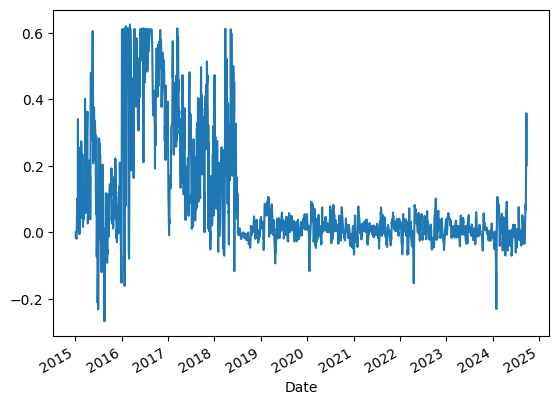

In [51]:
# for each day, keep the top 100 stocks based on pred
test = score_df
test['rank'] = test.groupby('Date')['pred'].rank(ascending=False)
test = test[test['rank']<=100]

# get average return 
test.groupby('Date')['5d_forward_return'].mean().plot()

In [85]:
score_df[score_df.isnull().T.any()]

,Date,Symbol,pred,vwap,Country,Beta,Momentum,Size,EarningsYield,ResidualVolatility,...,Computers,Transport,BasicChemicals,Coal,ElectricalEquipment,DefenseMilitary,NonBankFinance,Steel,Media,vwap_next
1833424,2015-01-26,000562.SZ,0.006385,268.991960,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034665,2015-05-20,600832.SH,0.007571,403.406390,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034819,2015-05-20,601299.SH,0.007571,37.071986,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2037532,2015-05-21,601268.SH,0.006813,2.335324,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2134189,2015-07-13,000594.SZ,0.008689,16.247937,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11036543,2024-10-09,688799.SH,0.004284,49.196337,1.0,0.604309,0.025791,-2.260503,-0.127695,-1.255098,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11036544,2024-10-09,688800.SH,0.000728,50.025618,1.0,1.943637,-2.594481,-2.039157,-0.918324,-0.309966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11036545,2024-10-09,688819.SH,0.002362,39.051405,1.0,1.207558,-0.485384,-0.432897,0.480913,-0.537843,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
11036546,2024-10-09,688981.SH,-0.001240,81.302010,1.0,0.167431,0.414427,1.368119,-2.261422,2.146076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [86]:










index_data_dict = {
    '000905.SH': 'idx__csi500_weight.parquet',
    '000300.SH': 'idx__csi300_weight.parquet',
    '000852.SH': 'idx__csi1000_weight.parquet',
}

# get index weight
index_weight = pd.read_parquet(os.path.join(fc.BARR_DIR, index_data_dict[chosen_index]))
index_weight = index_weight[['Date','Symbol', 'Weight']]
index_weight['Date'] = pd.to_datetime(index_weight['Date'])
index_weight = pd.merge(index_weight, return_df, on=['Date', 'Symbol'], how='left')
index_weight.dropna(inplace=True)

# get index return
index_return = pd.read_csv(f'{chosen_index}.csv')[['ts_code', 'trade_date', 'close']]
index_return['trade_date'] = pd.to_datetime(index_return['trade_date'], format='%Y%m%d')
index_return = index_return.loc[(index_return.trade_date >= startdate) & (index_return.trade_date <= enddate), ['ts_code','trade_date', 'close']]
index_return.columns = ['index', 'Date', 'index_close']

# define barra and industry list
barra_list = ['Beta', 'Momentum', 'Size', 'EarningsYield', 'ResidualVolatility', 'Growth',
    'BooktoPrice', 'Leverage', 'Liquidity', 'NonlinearSize']

barra_std_list = [barra_ + '_std' for barra_ in barra_list]

industry_list = ['Bank',
    'RealEstate', 'Pharmaceutical', 'CateringTourism',
    'CommercialRetailing', 'Mechanical', 'ConstructionMaterials',
    'HouseholdAppliances', 'TextileApparel', 'FoodBeverage',
    'ElectronicComponents', 'Automobile', 'LightManufacturing',
    'PowerUtilities', 'Comprehensive', 'Communications', 'Others',
    'PetroleumPetrochemical', 'NonferrousMetals', 'AgricultureFarming',
    'Architecture', 'Computers', 'Transport', 'BasicChemicals', 'Coal',
    'ElectricalEquipment', 'DefenseMilitary', 'NonBankFinance', 'Steel',
    'Media']

# get index barra and industry
df_index = pd.DataFrame(columns=barra_list + industry_list + barra_std_list)
for _date, _df in index_weight.groupby('Date'):
    # average index barra
    df_index.loc[_date, barra_list] = np.average(_df[barra_list], weights=_df['Weight'], axis=0)
#     # average index barra std
#     df_index.loc[_date, barra_std_list] = np.average(
#             (_df[barra_list] - df_index.loc[_date, barra_list]) ** 2, weights=_df['Weight'],
#             axis=0) ** 0.5
    # industry weight in index
    df_index.loc[_date, industry_list] = np.average(_df[industry_list], weights=_df['Weight'], axis=0)

# calculate barra limit
for _barra in barra_list:
    df_index[_barra + '_lower'] = df_index[_barra] - barra_limit
    df_index[_barra + '_upper'] = df_index[_barra] + barra_limit

# only consider stocks in index
score_df = pd.merge(score_df, index_weight[['Date', 'Symbol', 'Weight']], on=['Date', 'Symbol'], how = 'left')
# score_df = score_df[score_df['Weight'].notna()]

date_list = score_df['Date'].drop_duplicates().sort_values().to_list()
opt_weight = {}  # 字典形式储存结果
initial_asset = 1000
asset_record = pd.DataFrame(columns=['asset'])  # 纪录每日净值
holding_record = {}  # 持仓权重，尾盘更新
holding_record[date_list[0]] = pd.DataFrame({'Symbol':['cash'],
                                                'past_value':[initial_asset]}).set_index('Symbol')

# initial record dataframe
turnover_record = pd.DataFrame(columns=['turnover_rate'])  # 纪录换手率
# 记录Barra持仓
barra_daily_record = {
    'Beta': pd.DataFrame(columns=['index', 'diff', 'barra']),
    'Momentum': pd.DataFrame(columns=['index', 'diff', 'barra']),
    'Size': pd.DataFrame(columns=['index', 'diff', 'barra']),
    'EarningsYield': pd.DataFrame(columns=['index', 'diff', 'barra']),
    'ResidualVolatility': pd.DataFrame(columns=['index', 'diff', 'barra']),
    'Growth': pd.DataFrame(columns=['index', 'diff', 'barra']),
    'BooktoPrice': pd.DataFrame(columns=['index', 'diff', 'barra']),
    'Leverage': pd.DataFrame(columns=['index', 'diff', 'barra']),
    'Liquidity': pd.DataFrame(columns=['index', 'diff', 'barra']),
    'NonlinearSize': pd.DataFrame(columns=['index', 'diff', 'barra'])
}



In [45]:

for date_num in tqdm(range(0, len(date_list) - 1)):
    _date = date_list[date_num]
    next_date = date_list[date_num + 1]
    stock_today = score_df[score_df['Date'] == _date]
    stock_today.dropna(subset='vwap',inplace=True)
    index_today = df_index.loc[_date]
    holding_df = holding_record[_date]

    past_weight = holding_df.reset_index()
    past_weight['past_value'] = past_weight['past_value'] / past_weight['past_value'].sum()
    past_weight.columns = ['Symbol', 'past_weight']
    past_weight = past_weight[past_weight['Symbol'] != 'cash']

    # at 35, new stocks are added to stock today
    past_weight = pd.merge(left=stock_today[['Symbol']], right=past_weight,
                                on='Symbol', how='outer')
    past_weight.fillna(0, inplace=True)
    stock_today = pd.merge(left=stock_today, right=past_weight[['Symbol']],
                                on='Symbol', how='outer')
    stock_today['Date'] = _date


    barra_limit_tmp = barra_limit
    # 可能有突然被收购股
    nan_df = stock_today[pd.isna(stock_today['Country'])]
    if len(nan_df) > 0:
        drop_list = list(nan_df['Symbol'])
        stock_today_drop = stock_today[~stock_today['Symbol'].isin(drop_list)]
        past_weight_drop = past_weight[~past_weight['Symbol'].isin(drop_list)]

        try:
            opt_weight[_date], status = port_opt(['pred'], industry_list, barra_list, past_weight_drop,
                                                    stock_today_drop, index_today, barra_limit_tmp, turnover=0.15)
        except:
            try:
                opt_weight[_date], status = port_opt(['pred'], industry_list, barra_list, past_weight_drop,
                                                        stock_today_drop, index_today, barra_limit_tmp, turnover=0.2)
            except:
                    barra_limit_tmp += barra_limit/2
                    opt_weight[_date], status = port_opt(['pred'], industry_list, barra_list, past_weight_drop,
                                                        stock_today_drop, index_today, barra_limit_tmp, turnover=0.2)
        turnover = 0.2
        while status not in ['optimal', 'optimal_inaccurate']:
            turnover += 0.05
            opt_weight[_date], status = port_opt(['pred'], industry_list, barra_list, past_weight_drop,
                                                    stock_today_drop, index_today, barra_limit_tmp, turnover=turnover)
        # trading record
        trade_target = pd.DataFrame(opt_weight[_date].values(), index=opt_weight[_date].keys()).reset_index()
        trade_target.columns = ['Symbol', 'trade_weight']
        nan_df = pd.DataFrame({'Symbol':drop_list})
        nan_df['trade_weight'] = 0
        trade_target = pd.concat([trade_target, nan_df], axis=0)
        today_stock_return = return_df[return_df['Date'] == _date][['Date', 'Symbol', 'vwap', 'vwap_next']]
        # nan df could contain stocks that are not in return_df, need to fill return df's vwap and vwap_next
        holding_df, turnover_rate = trade_cal(past_weight, holding_df, trade_target, today_stock_return, sell_trade_cost=0.0005, buy_trade_cost=0.0005, non_trade=date_num%trade_freq, drop_list = drop_list)   

    else:
        try:
            opt_weight[_date], status = port_opt(['pred'], industry_list, barra_list, past_weight,
                                                    stock_today, index_today, barra_limit_tmp, turnover=0.15)
        except:
            try:
                opt_weight[_date], status = port_opt(['pred'], industry_list, barra_list, past_weight,
                                                            stock_today, index_today, barra_limit_tmp, turnover=0.2)
            except:
                    barra_limit_tmp += barra_limit/2
                    opt_weight[_date], status = port_opt(['pred'], industry_list, barra_list, past_weight,
                                                        stock_today, index_today, barra_limit_tmp, turnover=0.2)
        turnover = 0.2
        while status not in ['optimal', 'optimal_inaccurate']:
            turnover += 0.05
            opt_weight[_date], status = port_opt(['pred'], industry_list, barra_list, past_weight,
                                                    stock_today, index_today, barra_limit_tmp, turnover=turnover)
            
        trade_target = pd.DataFrame(opt_weight[_date].values(), index=opt_weight[_date].keys()).reset_index()
        trade_target.columns = ['Symbol', 'trade_weight']
        today_stock_return = return_df[return_df['Date'] == _date][['Date', 'Symbol', 'vwap', 'vwap_next']]

        holding_df, turnover_rate = trade_cal(past_weight, holding_df, trade_target, today_stock_return, sell_trade_cost=0.0005, buy_trade_cost=0.0005,non_trade=date_num%trade_freq)

    # hodling record
    holding_record[next_date] = holding_df
    asset_record.loc[next_date] = holding_df['past_value'].sum() / initial_asset
    turnover_record.loc[next_date] = turnover_rate
    today_mkt = pd.DataFrame(holding_df).reset_index()
    today_mkt['Date'] = next_date

    # calculate barra difference
    today_barra = pd.DataFrame(holding_df).reset_index()
    today_barra['Date'] = next_date
    today_barra_all = barra_df[barra_df['Date'] == next_date]
    today_barra = pd.merge(left=today_barra, right=today_barra_all, on=['Symbol', 'Date'], how='inner')
    today_barra[barra_list] = today_barra[barra_list] * today_barra['past_value'].values.reshape(-1, 1) \
                                / today_mkt['past_value'].sum()
    index_next = df_index.loc[next_date]

    barra_list
    for _barr in barra_list:
        diff = today_barra[_barr].sum() - index_next[_barr]
        barra_daily_record[_barr].loc[next_date] = [index_next[_barr], diff, today_barra[_barr].sum()]

# CALCULATE ABSOLUTE RETURN
asset_record.loc[asset_record.index[0] - timedelta(days=1), 'asset'] = 1  # initialize the first day as 1
asset_record.sort_index(inplace=True)
asset_record.reset_index(inplace=True)
asset_record.columns = ['Date', 'origin']
index_init = index_return[index_return['Date'] <= asset_record['Date'].iloc[0]]['index_close'].iloc[-1]
asset_record = pd.merge(left=asset_record, right=index_return[['Date', 'index_close']], on=['Date'], how='left')
asset_record.fillna(index_init, inplace=True) 
asset_record['index_close'] = asset_record['index_close'] / index_init
asset_record['asset'] = asset_record['origin'] / asset_record['index_close']

asset_record['return_rate'] = asset_record['asset'].pct_change()
asset_record['max_draw_down'] = asset_record['asset'].expanding().max() 
asset_record['max_draw_down'] = asset_record['asset'] / asset_record['max_draw_down'] - 1  
asset_record['trade_year'] = asset_record['Date'].dt.year

if not os.path.exists('./backtest_sample'):
    os.makedirs('./backtest_sample')

# ABSOLUTE RETURN
fig, ax1 = plt.subplots(figsize=(10, 5)) 
ax2 = ax1.twinx()
bar_width = pd.Timedelta(days=1)  # 设置柱状图柱状的宽度为1天
ax2.bar(list(asset_record['Date']), list(asset_record['asset'] - 1), width=bar_width,
        color='skyblue', label='cumulative alpha', alpha=0.5)
ax1.plot(list(asset_record['Date']), list(asset_record['origin']), color='red', label='portfolio value')
ax1.plot(list(asset_record['Date']), list(asset_record['index_close']), color='black', label='index value')
plt.title('Portfolio Value and Index Value')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')
plt.savefig(r"./backtest_sample/abs_asset.jpg", dpi=1000)

# ALPHA
fig, ax1 = plt.subplots(figsize=(10, 5)) 
ax2 = ax1.twinx()
bar_width = pd.Timedelta(days=1)  
ax2.bar(asset_record['Date'], asset_record['max_draw_down'], width=bar_width,
        color='skyblue', label='maximum drawdown', alpha=0.5)
ax1.plot(list(asset_record['Date']), list(asset_record['asset']), color='red', label='净值走势')
plt.title('Apha and Max Drawdown')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')
plt.savefig(r"./backtest_sample/increase_asset.jpg", dpi=1000)


# TURNOVER
fig, ax1 = plt.subplots(figsize=(10, 5))  
turnover_figure = turnover_record.iloc[1:]  
turnover_figure.to_excel(r"./backtest_sample/turnover_rate.xlsx")
ax1.plot(list(turnover_figure.index), list(turnover_figure['turnover_rate']), color='red', label='turnover')
plt.title('Turnover')
lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='upper left')
plt.savefig(r"./backtest_sample/turnover_rate.jpg", dpi=1000)



# BARRA
for name in barra_daily_record.keys():
    fig, ax = plt.subplots(figsize=(10, 5)) 
    df = barra_daily_record[name]
    ax.plot(list(df.index), list(df['index']), color='red', label='index %s barra'%name)
    ax2 = ax.twinx()
    ax2.plot(list(df.index), [barra_limit] * len(df.index), color='blue', label='%supper limit'%name)
    ax2.plot(list(df.index), [-barra_limit] * len(df.index), color='blue', label='%supper limit'%name)
    ax2.plot(list(df.index), list(df['diff']), color='y', label='portfolio %s next day diff'%name)
    ax2.set_ylim(- 3*barra_limit, 3 * barra_limit)
    plt.title('%s barra record'%name)
    lines, labels = ax.get_legend_handles_labels()
    plt.legend(lines, labels, loc='upper left')
    plt.savefig(r"./backtest_sample/%s.jpg"%name, dpi=1000)


# close all figures
plt.close('all')


# yearly_return, sharpe, max_drawdown
return_yr = asset_record.groupby(['trade_year']).last().reset_index()
yr_days = asset_record.groupby(['trade_year']).size().reset_index()
yr_days.columns = ['trade_year', 'days']
return_yr = pd.merge(return_yr, yr_days, on=['trade_year'], how='left')
return_yr['asset_yr'] = return_yr['asset'] / return_yr['asset'].shift(1).fillna(1)
return_yr['return_yr'] = round(return_yr['asset_yr'] ** (252 / return_yr['days']) - 1, 5)
sharpe_yr = ((asset_record.groupby(['trade_year'])['return_rate'].mean()
                / asset_record.groupby(['trade_year'])['return_rate'].std()) * np.sqrt(252)).reset_index()
sharpe_yr.columns = ['trade_year', 'sharpe_yr']
max_drawdown_yr = (asset_record.groupby(['trade_year'])['max_draw_down'].min()).reset_index()
yr = pd.merge(return_yr[['trade_year', 'return_yr']], sharpe_yr, on=['trade_year'], how='left')
yr = pd.merge(yr, max_drawdown_yr, on=['trade_year'], how='left')
yr.to_excel(r"./backtest_sample/yr_record.xlsx", index=False)

# xlsx
return_all = asset_record.tail(1)
all_days = asset_record.shape[0]
return_all['return_all'] = round(return_all['asset'] ** (252 / all_days) - 1, 5)
sharpe_all = ((asset_record['return_rate'].mean()
                / asset_record['return_rate'].std()) * np.sqrt(252))
max_drawdown_all = (asset_record['max_draw_down'].min())
all_record = pd.DataFrame({'return_all': [return_all['return_all'].iloc[0]], 'sharpe_all': sharpe_all,
                        'max_drawdown_all': max_drawdown_all})
all_record.to_excel(r"./backtest_sample/all_record.xlsx", index=False)

 12%|█▏        | 289/2371 [00:53<05:29,  6.33it/s]